In [1]:
import pickle
import numpy as np
#import tensorflow as tf
from sklearn.preprocessing import scale

#from keras.models import Sequential
#from keras.optimizers import SGD, Adam, Adagrad
#from keras import backend as K
#from keras.layers import Embedding
#from keras.layers import Dense, Reshape, Concatenate, Activation, Dropout
#from keras.callbacks import ModelCheckpoint

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_cache = 'cache/train.pickle'
train_labels_cache = 'cache/train-labels.npy'
validation_cache = 'cache/validation.pickle'
validation_labels_cache = 'cache/validation-labels.npy'
test_cache = 'cache/test.pickle'
test_labels_cache = 'cache/test-labels.npy'
competition_test_cache = 'cache/competition-test.pickle'
metadata_cache = 'cache/metadata.pickle'

In [3]:
train_cache = 'train2.pickle'
train_labels_cache = 'train-labels2.npy'
validation_cache = 'validation2.pickle'
validation_labels_cache = 'validation-labels2.npy'
test_cache = 'test2.pickle'
test_labels_cache = 'test-labels2.npy'
competition_test_cache = 'competition-test2.pickle'
metadata_cache = 'metadata2.pickle'

In [4]:
train = pd.read_pickle(train_cache)
validation = pd.read_pickle(validation_cache)
test = pd.read_pickle(test_cache)

train_labels = np.load(train_labels_cache)
validation_labels = np.load(validation_labels_cache)
test_labels = np.load(test_labels_cache)

competition_test = pd.read_pickle(competition_test_cache)
with open(metadata_cache, 'rb') as handle:
    metadata = pickle.load(handle)

In [5]:
# train['labels'] = train_labels
# train = train.sort_values(['WEEK_OF_YEAR', 'DAY_OF_WEEK', 'QUARTER_HOUR'])
# train_labels = train['labels'].values
# train = train.drop('labels', axis=1)


In [7]:
# validation['labels'] = validation_labels
# validation = validation.sort_values(['WEEK_OF_YEAR', 'DAY_OF_WEEK', 'QUARTER_HOUR'])
# validation_labels = validation['labels'].values
# validation = validation.drop('labels', axis=1)

In [8]:
# test['labels'] = test_labels
# test = test.sort_values(['WEEK_OF_YEAR', 'DAY_OF_WEEK', 'QUARTER_HOUR'])
# test_labels = test['labels'].values
# test = test.drop('labels', axis=1)

In [6]:
train

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,LEN,dt_2014-08-14 00:00:00,dt_2014-09-30 00:00:00,dt_2014-10-06 00:00:00,dt_2014-11-01 00:00:00,dt_2014-12-21 00:00:00,QUARTER_HOUR,DAY_OF_WEEK,WEEK_OF_YEAR,ORIGIN_CALL_ENCODED,TAXI_ID_ENCODED,ORIGIN_STAND_ENCODED
849345,1388385424620000325,A,19967.0,NaN,20000325,2013-12-30 06:37:04,"[[-8.638839,41.141619],[-8.637138,41.13909],[-...",5085,0,1,0,0,0,26.0,0,0,7377,205,0
849408,1388388124620000602,B,NaN,24.0,20000602,2013-12-30 07:22:04,"[[-8.589195,41.169726],[-8.588979,41.169699],[...",675,0,1,0,0,0,29.0,0,0,0,374,24
849569,1388388162620000051,A,26053.0,NaN,20000051,2013-12-30 07:22:42,"[[-8.570259,41.15952],[-8.57016,41.158836],[-8...",780,0,1,0,0,0,29.0,0,0,9237,41,0
849315,1388388549620000081,A,8597.0,NaN,20000081,2013-12-30 07:29:09,"[[-8.634708,41.166126],[-8.634699,41.166],[-8....",510,0,1,0,0,0,30.0,0,0,2414,61,0
849276,1388388345620000166,A,3578.0,NaN,20000166,2013-12-30 07:25:45,"[[-8.623674,41.161275],[-8.62371,41.161266],[-...",840,0,1,0,0,0,30.0,0,0,473,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847893,1388336905620000682,B,NaN,33.0,20000682,2013-12-29 17:08:25,"[[-8.600193,41.18274],[-8.600301,41.182821],[-...",855,0,0,0,0,1,69.0,6,51,0,422,33
847868,1388337036620000007,A,2002.0,NaN,20000007,2013-12-29 17:10:36,"[[-8.574696,41.142717],[-8.574696,41.142717],[...",750,0,0,0,0,1,69.0,6,51,2,6,0
847803,1388336906620000157,C,NaN,NaN,20000157,2013-12-29 17:08:26,"[[-8.629416,41.158926],[-8.629434,41.158926],[...",570,0,0,0,0,1,69.0,6,51,0,107,0
848094,1388337167620000453,A,2002.0,NaN,20000453,2013-12-29 17:12:47,"[[-8.620875,41.149638],[-8.620929,41.150106],[...",1215,0,0,0,0,1,69.0,6,51,2,283,0


In [17]:
metadata

{'n_quarter_hours': 96,
 'n_days_per_week': 7,
 'n_weeks_per_year': 52,
 'n_client_ids': 20778,
 'n_taxi_ids': 440,
 'n_stand_ids': 64}

In [15]:
competition_test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,dt_2014-08-14 00:00:00,dt_2014-09-30 00:00:00,dt_2014-10-06 00:00:00,dt_2014-11-01 00:00:00,dt_2014-12-21 00:00:00,QUARTER_HOUR,DAY_OF_WEEK,WEEK_OF_YEAR,ORIGIN_CALL_ENCODED,TAXI_ID_ENCODED,ORIGIN_STAND_ENCODED
0,T1,B,NaN,15.0,20000542,2014-08-14 17:57:17,1,0,0,0,0,72.0,3,32,0,340,15
1,T2,B,NaN,57.0,20000108,2014-08-14 17:50:11,1,0,0,0,0,71.0,3,32,0,78,57
2,T3,B,NaN,15.0,20000370,2014-08-14 17:49:28,1,0,0,0,0,71.0,3,32,0,237,15
3,T4,B,NaN,53.0,20000492,2014-08-14 17:58:10,1,0,0,0,0,72.0,3,32,0,307,53
4,T5,B,NaN,18.0,20000621,2014-08-14 17:59:37,1,0,0,0,0,72.0,3,32,0,391,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,2014-12-21 14:18:05,0,0,0,0,1,57.0,6,50,20763,269,0
316,T324,B,NaN,53.0,20000020,2014-12-21 14:06:42,0,0,0,0,1,56.0,6,50,0,17,53
317,T325,C,NaN,NaN,20000207,2014-12-21 14:28:41,0,0,0,0,1,58.0,6,50,0,139,0
318,T326,A,76232.0,NaN,20000667,2014-12-21 14:26:20,0,0,0,0,1,58.0,6,50,20771,410,0


In [9]:
def process_features(df):
    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED','ORIGIN_STAND_ENCODED',
                           'dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
                           'dt_2014-12-21 00:00:00']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED',
#                            'ORIGIN_STAND_ENCODED']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_STAND_ENCODED','dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
#                           'dt_2014-12-21 00:00:00']].values)

In [10]:
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.embed_quarter_hour = nn.Embedding(metadata['n_quarter_hours'], 15)
        self.embed_day_of_week = nn.Embedding(metadata['n_days_per_week'], 15)
        self.embed_week_of_year = nn.Embedding(metadata['n_weeks_per_year'],15)
        self.embed_client_ids = nn.Embedding(metadata['n_client_ids'],15)
        self.embed_taxi_ids = nn.Embedding(metadata['n_taxi_ids'],15)
        self.embed_stand_ids = nn.Embedding(metadata['n_stand_ids'],15)

        self.lstm = nn.LSTM(input_size=95, hidden_size=350, num_layers=3, batch_first=True, dropout=0.6)
        self.fc = nn.Linear(350, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        qhr = self.embed_quarter_hour(x[:,0].to(torch.int32))
        dow = self.embed_day_of_week(x[:,1].to(torch.int32))
        woy = self.embed_week_of_year(x[:,2].to(torch.int32))
        ci = self.embed_client_ids(x[:,3].to(torch.int32))
        ti = self.embed_taxi_ids(x[:,4].to(torch.int32))
        si = self.embed_stand_ids(x[:,5].to(torch.int32))
        x = torch.cat([qhr,dow,woy,ci,ti,si,x[:,6:]],axis=1)
        x = x.to(torch.float32)

        # Reshape input data to (batch_size, sequence_length, input_size) for LSTM
        x = x.view(x.size(0), 1, -1)

        x, _ = self.lstm(x)
        x = self.relu(x)
        x = self.fc(x[:, -1, :])

        return x


In [11]:
import torch.optim as optim
learning_rate = 0.0001
criterion = nn.MSELoss()
num_epochs = 230

In [34]:
x=process_features(train)
x.shape

torch.Size([326542, 11])

In [53]:
train_data = process_features(train)

In [54]:
validate_data = process_features(validation)

In [56]:
validate_data

tensor([[68.,  0., 17.,  ...,  1.,  0.,  0.],
        [32.,  4.,  3.,  ...,  0.,  0.,  0.],
        [10.,  5., 19.,  ...,  0.,  1.,  0.],
        ...,
        [72.,  2., 38.,  ...,  1.,  0.,  0.],
        [34.,  4., 38.,  ...,  0.,  0.,  0.],
        [69.,  1., 26.,  ...,  1.,  0.,  0.]], dtype=torch.float64)

In [58]:
train_labels_distance = train[['LEN']].values

In [61]:
train_labels_distance = train_labels_distance.flatten()

In [62]:
train_labels_distance

array([ 900, 1470,  840, ...,  480,  465,  615], dtype=int64)

In [12]:
train_data = process_features(train)
train_data = TensorDataset(train_data, torch.tensor(train_labels))
validate_data = process_features(validation)
validate_data = TensorDataset(validate_data,torch.tensor(validation_labels))
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validate_data, batch_size = BATCH_SIZE,shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
all_losses = []
train_loss = []
validation_losses = []

In [37]:
train_data

In [13]:
model = LSTMNet()
model = model.to(device)

In [14]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape targets
            targets = torch.reshape(targets,(-1,1))

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = torch.sqrt(criterion(outputs, targets))  # RMSE

            # Accumulate loss
            running_val_loss += loss.item()

    # Return average loss
    average_val_loss = running_val_loss / len(val_loader)
    return average_val_loss


In [15]:
def train_data(model, train_loader, val_loader, criterion, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        all_losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        validation_losses.append(val_loss/len(val_loader))
        print(f"Epoch: {epoch} Validation Loss:{val_loss/len(val_loader)}")
        PATH = f'model_state/model_epoch{epoch}.pth'     
        torch.save(model.state_dict(), PATH)

In [45]:
train_loader

In [16]:
train_data(model, train_loader, val_loader, criterion, 230) # use the training function you defined
val_loss = validate(model, val_loader, criterion)

Epoch: 0 Training Loss:1056.7565967715273
Epoch: 0 Validation Loss:1031.5336032443577
Epoch: 1 Training Loss:1024.6843582679485
Epoch: 1 Validation Loss:984.7820411964699
Epoch: 2 Training Loss:993.7164143529432
Epoch: 2 Validation Loss:970.9906864872685
Epoch: 3 Training Loss:963.7428912697915
Epoch: 3 Validation Loss:928.9774644639757
Epoch: 4 Training Loss:933.9015455694408
Epoch: 4 Validation Loss:900.2240962275753
Epoch: 5 Training Loss:905.0420501852484
Epoch: 5 Validation Loss:963.2954485857928
Epoch: 6 Training Loss:876.6170593548718
Epoch: 6 Validation Loss:837.3697261103878
Epoch: 7 Training Loss:850.4791796334484
Epoch: 7 Validation Loss:818.7326614945023
Epoch: 8 Training Loss:823.6355159125732
Epoch: 8 Validation Loss:799.2932445384838
Epoch: 9 Training Loss:799.287582481169
Epoch: 9 Validation Loss:758.8646195023148
Epoch: 10 Training Loss:775.621356988028
Epoch: 10 Validation Loss:730.4770146122685
Epoch: 11 Training Loss:753.2922838743203
Epoch: 11 Validation Loss:726.2

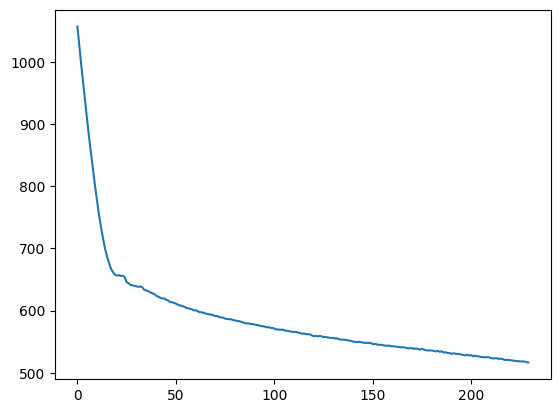

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

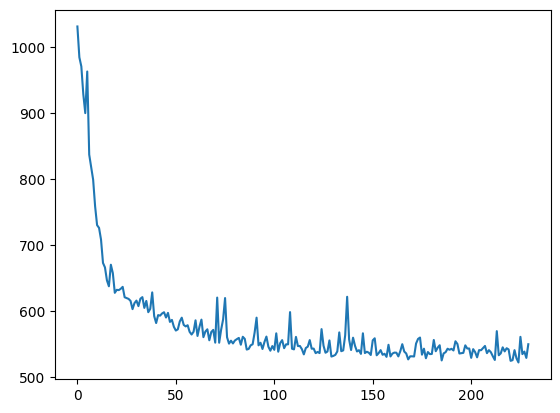

In [18]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(validation_losses)))

In [19]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [20]:
test_losses = []
for i in range(200):
    model.load_state_dict(torch.load(f'model_state/model_epoch{i}.pth'))
    test_losses.append(view_loss(model,process_features(test),torch.tensor(test_labels).to(torch.float32),criterion)/process_features(test).shape[0]*128)
    print(f"epoch: {i}, test loss: {view_loss(model, process_features(test), torch.tensor(test_labels).to(torch.float32), criterion)/process_features(test).shape[0]*128}")

epoch: 0, test loss: 1068.1451416015625
epoch: 1, test loss: 1020.4221801757812
epoch: 2, test loss: 982.00830078125
epoch: 3, test loss: 957.6951293945312
epoch: 4, test loss: 929.6134033203125
epoch: 5, test loss: 898.8275756835938
epoch: 6, test loss: 883.2615356445312
epoch: 7, test loss: 862.4177856445312
epoch: 8, test loss: 823.2922973632812
epoch: 9, test loss: 832.4445190429688
epoch: 10, test loss: 787.2133178710938
epoch: 11, test loss: 744.2935791015625
epoch: 12, test loss: 727.530517578125
epoch: 13, test loss: 698.9456787109375
epoch: 14, test loss: 692.0362548828125
epoch: 15, test loss: 679.9280395507812
epoch: 16, test loss: 674.8283081054688
epoch: 17, test loss: 689.47314453125
epoch: 18, test loss: 676.3732299804688
epoch: 19, test loss: 647.3180541992188
epoch: 20, test loss: 659.6088256835938
epoch: 21, test loss: 647.58935546875
epoch: 22, test loss: 669.6343383789062
epoch: 23, test loss: 659.9972534179688
epoch: 24, test loss: 652.242919921875
epoch: 25, test 

In [21]:
min(test_losses)

tensor(565.2191, device='cuda:0', grad_fn=<MulBackward0>)

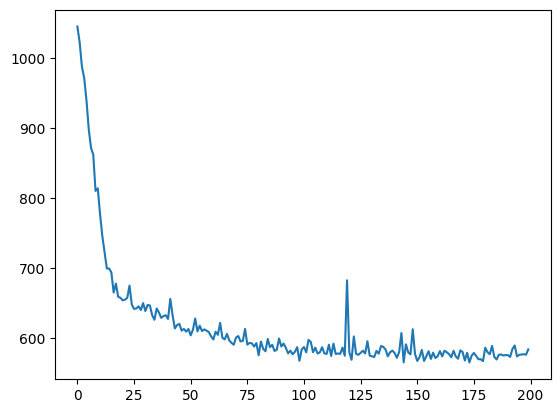

In [22]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(test_losses)))

In [23]:
print(model)

LSTMNet(
  (embed_quarter_hour): Embedding(96, 15)
  (embed_day_of_week): Embedding(7, 15)
  (embed_week_of_year): Embedding(52, 15)
  (embed_client_ids): Embedding(20778, 15)
  (embed_taxi_ids): Embedding(440, 15)
  (embed_stand_ids): Embedding(64, 15)
  (lstm): LSTM(95, 350, num_layers=3, batch_first=True, dropout=0.6)
  (fc): Linear(in_features=350, out_features=1, bias=True)
  (relu): ReLU()
)


In [31]:
min_index, min_value = min(enumerate(test_losses), key=lambda x: x[1])



In [32]:
min_index

173

In [33]:
model.load_state_dict(torch.load('model_state/model_epoch173.pth'))

<All keys matched successfully>

In [34]:
predict_input = torch.tensor(process_features(competition_test)).to(device)
print(predict_input.shape)

torch.Size([320, 11])


C:\Users\ikuto\AppData\Local\Temp\ipykernel_24320\1078090879.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict_input = torch.tensor(process_features(competition_test)).to(device)


In [35]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [36]:
out = predict(model)

In [37]:
embed_mlp_predict = pd.read_csv('test_public.csv')
embed_mlp_predict = embed_mlp_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
embed_mlp_predict= pd.concat([embed_mlp_predict, pd.DataFrame(predict_tensor)], axis=1)
embed_mlp_predict = embed_mlp_predict.rename(columns={0: 'TRAVEL_TIME'})
embed_mlp_predict[0:50]

,TRIP_ID,TRAVEL_TIME
0,T1,616.874390
1,T2,651.171875
2,T3,644.874878
3,T4,567.858948
4,T5,591.323730
5,T6,545.496094
6,T7,650.879517
7,T8,754.172363
8,T9,611.201965
9,T10,684.563843


In [33]:
embed_mlp_predict

,TRIP_ID,TRAVEL_TIME
0,T1,735.669617
1,T2,645.568665
2,T3,716.945129
3,T4,621.754333
4,T5,594.426697
...,...,...
315,T323,965.882874
316,T324,715.538025
317,T325,850.665833
318,T326,823.611450


In [38]:
embed_mlp_predict['TRAVEL_TIME'].mean()

826.3483

In [39]:
embed_mlp_predict.to_csv('Embedding_MLP_188_retrain.csv', index=False)

In [ ]:
a = process_features(train)
print(a[:,0])
embedding1 = torch.nn.Embedding(96, 10)
embedding2 = torch.nn.Embedding()
print(embedding(a[0,0].to(torch.int32)))

<function __main__.train_data(model, train_loader, val_loader, criterion, num_epochs)>